In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pysptools
import pysptools.spectro as spectro
import pandas as pd
import openpyxl # must include as engine when opening .xlsx files in p3.6
from openpyxl.workbook import Workbook 

In [17]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_spots.xlsx'
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
 
data = pd.read_excel(target_file, sheet_name = 'band_mean', header = None, index_col = None, engine='openpyxl')
#data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None, engine='openpyxl')
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None, engine='openpyxl')
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None, engine='openpyxl')

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'bad_age_idx' in locals():
    del bad_age_idx
if 'bad_band_idx' in locals():
    del bad_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
bad_band_idx = np.r_[226:230] # choose bands to drop by index
bad_age_idx = np.where((pix_count == 0))# | (age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48)) #  choose age to drop (two decimels)
if 'bad_age_idx' in locals():
    data = data.drop(np.r_[bad_age_idx], axis=0)
    #data_std = data_std.drop(np.r_[bad_age_idx], axis=0)
    age = np.delete(age, bad_age_idx)
    age_sd = np.delete(age_sd, bad_age_idx)
    age_n = np.delete(age_n, bad_age_idx)
    fan = np.delete(fan, bad_age_idx)
    unit = np.delete(unit, bad_age_idx)
    unique = np.delete(unique, bad_age_idx)
    pix_count = np.delete(pix_count, bad_age_idx)
    spots_meta = spots_meta.drop(np.r_[bad_age_idx], axis=0)
    
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    print('some ages dropped')
else:
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    print('No ages dropped')
    
# drop chosen values from dataset(s)
if 'bad_band_idx' in locals():
    data = data.drop(np.r_[bad_band_idx], axis=1)
    nm_names = np.delete(nm_names, bad_band_idx)
    #data.iloc[:,bad_band_idx] = 0 # if bad bands chosen, set band bands as 0 for PCA`
    #data_std.iloc[:,bad_band_idx] = 0
    
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    #data_plot.iloc[:,bad_band_idx] = np.nan
    #data_std_plot.iloc[:,bad_band_idx] = np.nan
    print('some bands dropped')
else:
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    #data_std_plot = data_std.copy()
    print('No bands dropped')

print(np.shape(data))

some ages dropped
some bands dropped
(22, 226)


In [16]:
# remove continum for each spectral profile

data_list = data.values.tolist()
n = len(age)
data_crs = []

for i in range(n):
    crs = spectro.convex_hull_removal(data_list[i], nm_names)
    data_crs.append(crs)

y=np.array(data_crs, dtype = list)

# store values
crs = []
cx = []
cy = []

for i in range(n):
    crs_vals = y[i][0]
    cx_vals = y[i][1]
    cy_vals = y[i][2]
    
    crs.append(crs_vals)
    cx.append(cx_vals)
    cy.append(cy_vals)

TypeError: m > k must hold

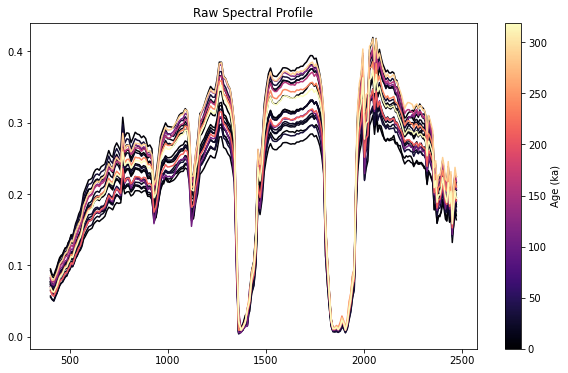

In [8]:
# plot continums
norm = plt.Normalize(vmin=min(age), vmax=max(age))

plt.figure(figsize = (10,6))
for i in range(n):
    plt.plot(nm_names, data.iloc[i], label = age[i],  color=plt.cm.magma(norm(age[i])))
    plt.title('Raw Spectral Profile')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

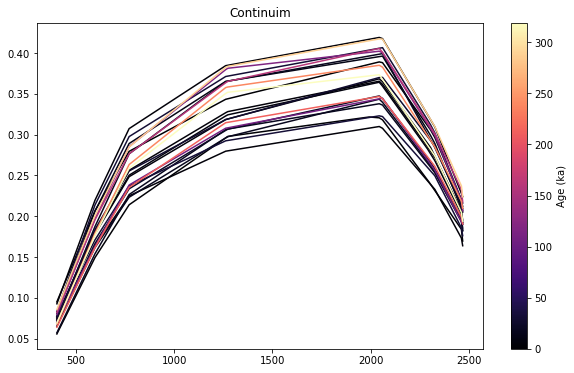

In [9]:
# plot continums
plt.figure(figsize = (10,6))
for i in range(n):
    plt.plot(cx[i],cy[i], label = age[i], color=plt.cm.magma(norm(age[i])))
    plt.title('Continuim')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

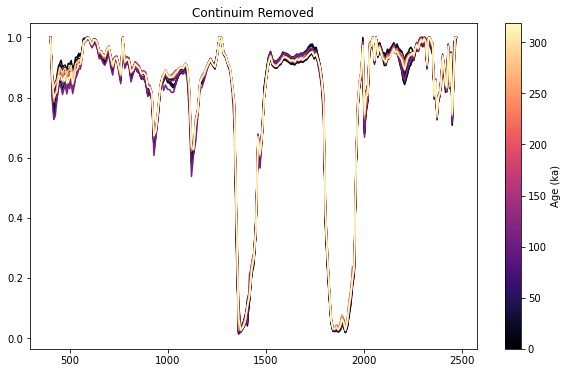

In [10]:
# plot continum removed spectra
plt.figure(figsize = (10,6))
for i in range(n):
    plt.plot(nm_names, crs[i], label = age[i], color=plt.cm.magma(norm(age[i])))
    plt.title('Continuim Removed')
    plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

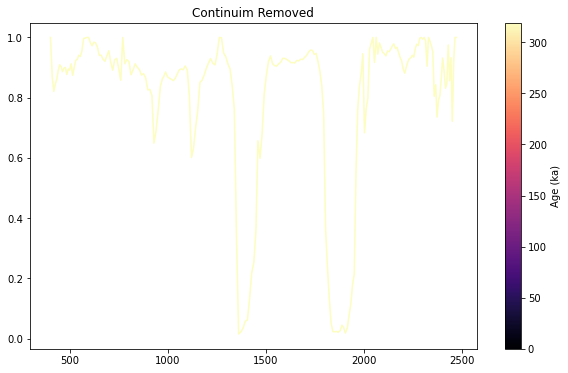

In [11]:
# plot continum removed spectra
plt.figure(figsize = (10,6))
plt.plot(nm_names, crs[0], label = age[0], color=plt.cm.magma(norm(age[i])))
plt.title('Continuim Removed')
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

In [12]:
# convert crs data to pandas, save as .csv
crs_df = pd.DataFrame(crs)

In [13]:
# convert contium values to same shape as nm i.e. interpoalte new y values at higher resolution.
cy_int = []
for i in range(n):
    interpolated_vals = np.interp(nm_names,cx[i],cy[i])
    cy_int.append(interpolated_vals)

# convert contium data to pandas, save as .csv
c_df = pd.DataFrame(cy_int)

In [14]:
#log(0) # stop, check file overwrite

outputs = r'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' # output location

# save as single .xlsx with multiple sheets
with pd.ExcelWriter(outputs + sensor + '_spots.xlsx', mode = 'a') as writer:  # ! Make sure mode = append !
    crs_df.to_excel(writer, sheet_name='continuum_removed', header = False, index = False)
    c_df.to_excel(writer, sheet_name='continuum', header = False, index = False)

### USGS Spectra

In [83]:
df_usgs = pd.read_csv(r'c:\Users\htccr\Documents\Aconquija\Terraspec\spec_libs\test.csv')
nm_usgs = df_usgs["Wavelength"].tolist()
kaolinite = df_usgs["Kaolinite"].tolist()
calcite = df_usgs["Calcite"].tolist()

kaolinite = np.interp(nm_names,nm_usgs,kaolinite).tolist()
calcite = np.interp(nm_names,nm_usgs,calcite).tolist()

(242.5, 2607.5)

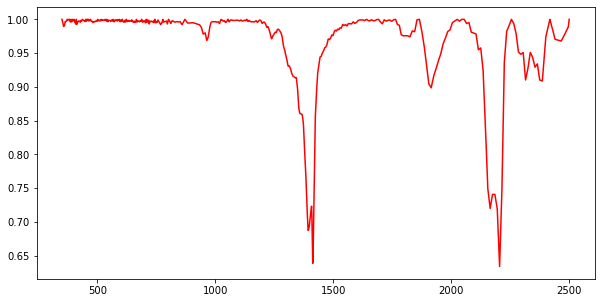

In [212]:
test = kaolinite
nm_names = list(nm_names)

test_cr = spectro.convex_hull_removal(test, nm_names)
plt.figure(figsize = (10,5))
plt.plot(nm_names, test_cr[0], color = 'red') # continuim removed
plt.xlim()

#plt.plot(test_cr[1], test_cr[2]) # continum
#plt.plot(nm, test)

In [215]:
# modify FeaturesConvexHullQuotient functions from 'spectro' to include feature assymetry

class FeaturesConvexHullQuotient_hc(spectro.SpectrumConvexHullQuotient): # added by hc
    """
    Remove the convex-hull of the signal by hull quotient.
    Auto-extract the features and calculate their associated
    statistics. A baseline can be applied to avoid non-significant features.
    If you want to restrict the analysis to one continuum, just set the intervale
    with the startContinuum and stopContinuum parameters. It is up to you
    to ascertain that the continuum interval defined by startContinuum and
    stopContinuum do not cross the spectrum. The bilateral function can be use
    to remove small spectrum noises before extracting the features.

    Parameters:
        spectrum: `list`
            1D HSI data (p), a spectrum.

        wvl: `list`
            Wavelength of each band (p x 1).

        startContinuum: `float`
            The wavelength value of the starting left continuum.

        stopContinuum: `float`
            The wavelength value of the ending right continuum.

        baseline: `float`
            Features extracted above the baseline are rejected,
            features extracted below the baseline are kept.

    Reference:
        Kokaly F. Raymond, PRISM: Processing Routines in IDL for Spectroscopic
        Measurements (Installation Manual and User's Guide, Version 1.0),
        U.S. Geological Survey,Reston, Virginia: 2011.
    """

    def __init__(self, spectrum, wvl, startContinuum=None, stopContinuum=None, baseline=0, normalize=False):
        if startContinuum != None and stopContinuum != None:
            start = 0
            for i in range(len(wvl)):
                if wvl[i] > startContinuum:
                    start = i
                    break
            stop = 0
            for i in range(len(wvl)):
                if wvl[i] > stopContinuum:
                    stop = i
                    break
            spectrum = spectrum[start:stop]
            wvl = wvl[start:stop]

        spectro.SpectrumConvexHullQuotient.__init__(self, spectrum, wvl, normalize)
        self.base_line = baseline
        self.features = []
        self.features_all = []
        self._extract_features()
        self._base_line_clean()

    def _all_features_number(self):
        return len(self.hx)

    def _features_number(self):
        return len(self.features)

    def _extract_features(self):
        for feat_no in range(self._all_features_number() - 1):
            start1 = self.hx[feat_no]
            end1 = self.hx[feat_no + 1]
            for i in range(len(self.wvl)):
                if start1 == self.wvl[i]: start2 = i
                if end1 == self.wvl[i]:
                    end2 = i
                    break
            spectrum = self.spectrum[start2:end2+1]
            wvl = self.wvl[start2:end2+1]
            crs = self.crs[start2:end2+1]
            hx = self.hx[feat_no:feat_no+2]
            hy = self.hy[feat_no:feat_no+2]
            feat = {'seq': feat_no,
                    'id': None,
                    'state': None,
                    'spectrum': spectrum,
                    'wvl': wvl,
                    'crs': crs,
                    'hx': hx,
                    'hy': hy,
                    'cstart_wvl': None,
                    'cstop_wvl': None,
                    'abs_wvl': None,
                    'abs_depth': None,
                    'area': None,
                    'cslope': None,
                    'FWHM_x': None,
                    'FWHM_y': None,
                    'FWHM_delta': None,
                    'left_w': None, # added by hc
                    'right_w': None, # added by hc
                    'lr_asym': None # added by hc
                    }
            self.features_all.append(feat)

    def _area(self, y):
        from scipy.integrate import trapz
        # Before the integration:
        # flip the crs curve to x axis
        # and start at y=0
        yy = [abs(p-1) for p in y]
        deltax = self.wvl[1] - self.wvl[0]
        area = trapz(yy, dx=deltax)
        return area

    def _FWHM(self, feat):
        # full_width_at_half_maximum
        import numpy as np
        # get the middle curve value -> y
        depth = np.min(feat['crs'])
        y = depth + ((1 - depth) / 2)
        left_wvl = 0
        # curve_centre is x at the minimum of the curve
        curve_centre = feat['wvl'].index(feat['abs_wvl'])
        # going from the curve center to left
        for i in range(curve_centre,-1,-1):
            if feat['crs'][i] >= y:
                left_wvl = feat['wvl'][i]
                break
        stop = len(feat['wvl'])
        right_wvl = 0
        # going from the curve center to right
        for i in range(curve_centre, stop):
            if feat['crs'][i] >= y:
                right_wvl = feat['wvl'][i]
                break
        delta = right_wvl - left_wvl
        FWHM_x = (left_wvl, right_wvl)
        FWHM_y = (y, y)
        left_w = np.abs(left_wvl - curve_centre) # added by hc
        right_w = np.abs(right_wvl - curve_centre) # added by hc
        lr_asym = left_w/right_w # added by hc
        return FWHM_x, FWHM_y, delta, left_w, right_w, lr_asym # added by hc

    def _add_stats(self, feat):
        import numpy as np
        feat['area'] = self._area(feat['crs'])
        feat['cstart_wvl'] = feat['wvl'][0]
        feat['cstop_wvl'] = feat['wvl'][-1]
        feat['abs_wvl'] = feat['wvl'][np.argmin(feat['crs'])]
        feat['abs_depth'] = np.min(feat['crs'])
        feat['cslope'] = (feat['hy'][1] - feat['hy'][0]) / (feat['hx'][1] - feat['hx'][0])
        feat['FWHM_x'], feat['FWHM_y'], feat['FWHM_delta'],feat['left_w'],feat['right_w'],feat['lr_asym'] = self._FWHM(feat) # added by hc

    def _base_line_clean(self):
        id = 1
        for feat in self.features_all:
            if min(feat['crs']) < self.base_line:
                feat['state'] = 'keep'
                feat['id'] = id
                id += 1
                self._add_stats(feat)
                self.features.append(feat)
            else:
                feat['state'] = 'reject'

    def get_number_of_kept_features(self):
        """
        Returns: `int`
            The number of features that are kept (below the baseline).
            Only theses features have a statistic report.
        """
        return self._features_number()


    def get_continuum_removed_spectrum(self, feat_no):
        """
        Returns: `list`
            Feature spectrum with convex hull removed (p).
        """
        return self.features[feat_no-1]['crs']


    def get_absorbtion_wavelength(self, feat_no):
        """
        Returns: `float`
            The wavelength at the feature minimum.
        """
        return self.features[feat_no-1]['abs_wvl']


    def get_absorbtion_depth(self, feat_no):
        """
        Returns: `float`
            The absorbtion value at the feature minimum.
        """
        return self.features[feat_no-1]['abs_depth']


    def get_continuum_slope(self, feat_no):
        """
        Returns: `float`
            The feature continuum slope.
        """
        return self.features[feat_no-1]['cslope']


    def get_area(self, feat_no):
        """
        Returns: `float`
            The feature area.
        """
        return self.features[feat_no-1]['area']


    def get_continuum_start_wavelength(self, feat_no):
        """
        Returns: `float`
            The continuum left start wavelength value.
        """
        return self.features[feat_no-1]['cstart_wvl']


    def get_continuum_stop_wavelength(self, feat_no):
        """
        Returns: `float`
            The continuum right end wavelength value.
        """
        return self.features[feat_no-1]['cstop_wvl']


    def get_full_width_at_half_maximum(self, feat_no):
        """
        Returns: `float`
            Width at half maximum.
        """
        return self.features[feat_no-1]['FWHM_delta']


    def print_stats(self, feat_no):
        """Print a statistic summary for a kept feature.

            Parameters:
                feat_no: `int or 'all'`
                  The feature number, if feat_no='all', print
                  stats for all the kept features.
        """
        if feat_no == 'all':
            for i in range(len(self.features)):
                self._print_stats1(self.features[i])
        else:
            feat = self.features[feat_no-1]
            self._print_stats1(feat)


    def _print_stats1(self, feat):
        print('Feature Stats')
        print('  ---------------------------')
        print('  feature number:',feat['id'])
        print('  ---------------------------')
        print('  area:',feat['area'])
        print('  ---------------------------')
        print('  continuum start wavelength:',feat['cstart_wvl'])
        print('  continuum stop wavelength:',feat['cstop_wvl'])
        print('  continuum slope:',feat['cslope'])
        print('  ---------------------------')
        print('  center wavelength:',feat['abs_wvl'])
        print('  depth:',feat['abs_depth'])
        print('  ---------------------------')
        print('  full-width at half maximum:',feat['FWHM_delta'])
        print('  assymetry (left/right)',feat['lr_asym'])
        print()


In [320]:
target_feat_df = pd.DataFrame()

In [321]:
# identify target feature, and 'search' range
target_feat = 2200
target_wvl_idx = np.where((np.array(nm_names) > 2000) & (np.array(nm_names) < 2300)) # choose range of feature search


idx_min = np.min(target_wvl_idx)
idx_max = np.max(target_wvl_idx)
data_target = data.loc[:,idx_min:idx_max]
data_target_list = data_target.values.tolist()
nm_names_target = nm_names[idx_min:idx_max]

target_feat_l = []
wvl_l = []
depth_l = []
area_l = []
lr_asym_l = []

n_spectrum = np.shape(data_target_list)[0]
for i in range(n_spectrum):
    print('-------- SPECTRUM ', i, ' --------')
    crs_features = FeaturesConvexHullQuotient_hc(data_target_list[i], nm_names_target, baseline=0.99, normalize=False)
    
    n_features = np.shape(crs_features.features)[0]
    for j in range(n_features):
        print('Feature ', j)
        print('   wavelength:', crs_features.features[j]['abs_wvl'])
        target_feat_l.append(target_feat)
        wvl_l.append(crs_features.features[j]['abs_wvl'])
        depth_l.append(1 - crs_features.features[j]['abs_depth'])
        area_l.append(crs_features.features[j]['area'])
        lr_asym_l.append(crs_features.features[j]['lr_asym'])

target_feat_df['wvl {}'.format(target_feat)] = wvl_l
target_feat_df['depth {}'.format(target_feat)] = depth_l
target_feat_df['area {}'.format(target_feat)] = area_l
target_feat_df['lr_asym {}'.format(target_feat)] = lr_asym_l

#target_feat_df = pd.DataFrame({ 'wvl {}'.format(target_feat): wvl_l,    # use if you want to reset the df each time
                               #'depth {}'.format(target_feat): depth_l,
                               #'area {}'.format(target_feat): area_l,
                               #'lr_asym {}'.format(target_feat): lr_asym_l})

-------- SPECTRUM  0  --------
Feature  0
   wavelength: 2208
-------- SPECTRUM  1  --------
Feature  0
   wavelength: 2209
-------- SPECTRUM  2  --------
Feature  0
   wavelength: 2208
-------- SPECTRUM  3  --------
Feature  0
   wavelength: 2208
-------- SPECTRUM  4  --------
Feature  0
   wavelength: 2205
-------- SPECTRUM  5  --------
Feature  0
   wavelength: 2207
-------- SPECTRUM  6  --------
Feature  0
   wavelength: 2209
-------- SPECTRUM  7  --------
Feature  0
   wavelength: 2209
-------- SPECTRUM  8  --------
Feature  0
   wavelength: 2207
-------- SPECTRUM  9  --------
Feature  0
   wavelength: 2209
-------- SPECTRUM  10  --------
Feature  0
   wavelength: 2208
-------- SPECTRUM  11  --------
Feature  0
   wavelength: 2209
-------- SPECTRUM  12  --------
Feature  0
   wavelength: 2209


In [293]:
# so far, I have modified the package code to include assymetry
# this loop will iterate through each feature and extract the chosen statistic
# next, create another loop higher up which does this for each 'age' spectra. 
# store as a dataframe for export. 
# will this work for PRISMA? Probably not...

n_spectrum = np.shape(data_list)[0]

for i in range(n_spectrum):
    print('-------- SPECTRUM ', i, ' --------')
    crs_features = FeaturesConvexHullQuotient_hc(data_list[i], nm_names, baseline=0.99, normalize=False)
    n_features = np.shape(crs_features.features)[0]

    for j in range(n_features):
        print('Feature ', j)
        print('   wavelength:', crs_features.features[j]['abs_wvl'])
        #print('   depth: ', 1 - crs_features.features[j]['abs_depth'])
        #print('   area: ', crs_features.features[j]['area'])

-------- SPECTRUM  0  --------
Feature  0
   wavelength: 418
Feature  1
   wavelength: 914
Feature  2
   wavelength: 1413
Feature  3
   wavelength: 1912
Feature  4
   wavelength: 2208
Feature  5
   wavelength: 2477
-------- SPECTRUM  1  --------
Feature  0
   wavelength: 424
Feature  1
   wavelength: 1414
Feature  2
   wavelength: 1912
Feature  3
   wavelength: 2209
Feature  4
   wavelength: 2481
-------- SPECTRUM  2  --------
Feature  0
   wavelength: 426
Feature  1
   wavelength: 1912
Feature  2
   wavelength: 2208
Feature  3
   wavelength: 2473
Feature  4
   wavelength: 2490
-------- SPECTRUM  3  --------
Feature  0
   wavelength: 422
Feature  1
   wavelength: 1414
Feature  2
   wavelength: 1912
Feature  3
   wavelength: 2209
Feature  4
   wavelength: 2487
Feature  5
   wavelength: 2494
-------- SPECTRUM  4  --------
Feature  0
   wavelength: 351
Feature  1
   wavelength: 424
Feature  2
   wavelength: 1048
Feature  3
   wavelength: 2205
Feature  4
   wavelength: 2479
Feature  5
   w

In [222]:
spectro.FeaturesConvexHullQuotient?

Init signature:
spectro.FeaturesConvexHullQuotient(
    spectrum,
    wvl,
    startContinuum=None,
    stopContinuum=None,
    baseline=0,
    normalize=False,
)
Docstring:     
Remove the convex-hull of the signal by hull quotient.
Auto-extract the features and calculate their associated
statistics. A baseline can be applied to avoid non-significant features.
If you want to restrict the analysis to one continuum, just set the intervale
with the startContinuum and stopContinuum parameters. It is up to you
to ascertain that the continuum interval defined by startContinuum and
stopContinuum do not cross the spectrum. The bilateral function can be use
to remove small spectrum noises before extracting the features.

Parameters:
    spectrum: `list`
        1D HSI data (p), a spectrum.

    wvl: `list`
        Wavelength of each band (p x 1).

    startContinuum: `float`
        The wavelength value of the starting left continuum.

    stopContinuum: `float`
        The wavelength value of

In [123]:
# extract features & print statistics
test_feat = FeaturesConvexHullQuotient_hc(test, nm_names, baseline=0.99, normalize=False)
print(1 - test_feat.features[1]['abs_depth'])
print(test_feat.features[1]['area'])
print(test_feat.features[1]['lr_asym'])
print(test_feat.features[1]['abs_wvl'])
#test_feat.display_convex_hull_quotient('test')

0.0313512888475167


TypeError: list indices must be integers or slices, not str

In [112]:
stats = test_feat.print_stats(feat_no = 'all')
print(stats)

Feature Stats
  ---------------------------
  feature number: 1
  ---------------------------
  area: 0.10877522650885962
  ---------------------------
  continuum start wavelength: 350
  continuum stop wavelength: 372
  continuum slope: 0.006078357954545454
  ---------------------------
  center wavelength: 357
  depth: 0.9895066806557044
  ---------------------------
  full-width at half maximum: 10
  assymetry (left/right) 0.9719101123595506

Feature Stats
  ---------------------------
  feature number: 2
  ---------------------------
  area: 1.4535325740614802
  ---------------------------
  continuum start wavelength: 871
  continuum stop wavelength: 1053
  continuum slope: 6.140109890109854e-06
  ---------------------------
  center wavelength: 964
  depth: 0.9686487111524833
  ---------------------------
  full-width at half maximum: 31
  assymetry (left/right) 0.9648526077097506

Feature Stats
  ---------------------------
  feature number: 3
  ---------------------------
  are

In [116]:
display(test_feat, feature='all')

TypeError: publish() got an unexpected keyword argument 'feature'